<a href="https://colab.research.google.com/github/AlfonsoRafel/Posgrado-IA---UBA/blob/master/11.%20Analisis%20de%20Datos/TP_Integrador_An%C3%A1lisis_de_datos5_Alfonso_Rafel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de datos - Trabajo final integrador

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQATNC-EBwF-LIbDVv_L0gkP2V6oKQzah5GRg&usqp=CAU"/>

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado.

Trabajaremos con un [dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv).

El objetivo es predecir si lloverá o no al día siguiente (variable *RainTomorrow*), en función datos metereológicos del día actual.


### Carga de Datos

In [142]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [143]:
%%capture
!pip install funpymodeling

In [144]:
import numpy as np
import pandas as pd
import sklearn as sk
import funpymodeling as fp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

In [145]:
file_path = '/content/gdrive/MyDrive/Alfonso/CEIA/Bimestre V/Análisis de Datos/weatherAUS.csv'
df = pd.read_csv(file_path)

### Funciones

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Separa el dataset en train y test, además de separar las variables de entrada de las de salida.
# inputs: df (DataFrame), test_size (Tamaño del test set) 
def split (df, test_size):
  X = df.iloc[: ,:-1]
  y = df.iloc[:,-1]
  train_set, test_set, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return train_set, test_set, y_train, y_test

# Elimina las filas con nan para las variables que poseen un porcentaje de nan < percent
def drop_nan (X, y, percent = 5):
  y = y.dropna(axis=0)
  X = X[X.index.isin(y.index)]

  status = fp.status(X)
  data_nan = status[['variable','p_nan']][(status['p_nan']<percent/100) & (status['p_nan']>0)]
  len_old = X.shape[0]
  X_new = X.dropna(subset=data_nan.variable.to_list())
  len_new = X_new.shape[0]
  left = round(100-len_new/len_old*100,2)
  return X_new, y, left

def simple_imputer(df, var, strategy): 
  imputer = SimpleImputer(strategy= strategy,add_indicator=True)
  imp = imputer.fit_transform(df[var].values.reshape(-1, 1))
  df.loc[:, var] = imp[:, 0]
  return df


def one_hot_encoder(col):
  ohe_encoder = OneHotEncoder(categories='auto',drop=None, sparse=False) 
  ohe = ohe_encoder.fit_transform(col.values.reshape(-1, 1))
  cat_names = np.concatenate(ohe_encoder.categories_).ravel()
  enconded_vars = pd.DataFrame(ohe, columns=cat_names).astype(int)
  return enconded_vars


In [147]:
def preprocessing(X, y):
  X, y, left = drop_nan (X, y, percent= 5)
  X.loc[:,:] = simple_imputer(X, 'Cloud3pm', strategy='mean')
  X.loc[:,:] = simple_imputer(X, 'Cloud9am', strategy='mean')
  X.loc[:,'Cloud3pm'] = X['Cloud3pm'].round()
  X.loc[:, 'Cloud9am'] = X['Cloud9am'].round()

  X.loc[:,:] = simple_imputer(X, 'Pressure3pm', strategy='mean')
  X.loc[:,:] = simple_imputer(X, 'Pressure9am', strategy='mean')

  X.loc[:,:] = simple_imputer(X, 'Evaporation', strategy='median')
  X.loc[:,:] = simple_imputer(X, 'Sunshine', strategy='median')
  X.loc[:,:] = simple_imputer(X, 'WindGustSpeed', strategy='median')
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindDir9am'] = X.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)

  dic = {'SE': 135, 'SSE': 157.5, 'W': 270, 'N':0, 'ENE':67.5, 'NW': 315, 'SSW': 202.5, 'SW':225, 'ESE': 112.5,
       'S': 180, 'NNW': 337.5, 'Faltante': -1, 'NNE': 22.5, 'E': 90, 'WSW': 247.5, 'WNW': 292.5, 'NE': 45}
  
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].map(dic)
  X.loc[:, 'WindDir9am'] = X['WindDir9am'].map(dic)
  X.loc[:, 'WindDir3pm'] = X['WindDir3pm'].map(dic)

  X.loc[:, 'RainToday'] = X.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
  y = y.map({'No': 0, 'Yes': 1})
  y = y[y.index.isin(X.index)]

  date = X.Date.str.split(pat='-', expand=True)
  encoded_locations = one_hot_encoder(X['Location'])
  
  X.reset_index(drop=True, inplace=True)
  date.reset_index(drop=True, inplace=True)
  encoded_locations.reset_index(drop=True, inplace=True)
  X = pd.concat([X, date, encoded_locations], axis=1)
  X = X.drop(['Location', 'Date'], axis=1)
  return X, y,left

### 1. Análisis exploratorio inicial

Luego de cargar el dataset imprimimos las 5 primeras filas para tener una comprensión global del contenido.

In [148]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Posteriormente generamos una tabla con la cantidad y porcentaje de Nans y ceros, ademas de las clases únicas y tipo por variable. De aquí podemos identificar rápidamente que contamos con datos numéricos (float64) y otros que podrían ser categóricos o hasta compuestos (object).  

In [149]:
fp.status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Date,0,0.000000,0,0.000000,3436,object
1,Location,0,0.000000,0,0.000000,49,object
2,MinTemp,1485,0.010209,159,0.001093,389,float64
3,MaxTemp,1261,0.008669,14,0.000096,505,float64
4,Rainfall,3261,0.022419,91080,0.626152,681,float64
5,Evaporation,62790,0.431665,244,0.001677,358,float64
6,Sunshine,69835,0.480098,2359,0.016218,145,float64
7,WindGustDir,10326,0.070989,0,0.000000,16,object
8,WindGustSpeed,10263,0.070555,0,0.000000,67,float64
9,WindDir9am,10566,0.072639,0,0.000000,16,object


Con ayuda de la tabla anterior podemos clasficar las varaibles según tipo (object, float64 o int32/64). Luego utilizamos también el método value_counts() para validar que los valores únicos de ciertas variables sean enteros, más allá de haber sido levantados como de punto flotante.
A continuación la clasificación:

- Fecha/Hora: Date 
- Numéricas:
    - Discretas: Cloud9am, Cloud3pm
    - Continuas: MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm
- Categóricas:
    - Nominales: Location, WindGustDir, WindDir9pm, WindDir3pm, RainToday, RainTomorrow
    - Ordinales: N/A

Luego volvemos a realizar la clasificación entre entrada y salida:

- Variables de Entrada: Date, Location, Cloud9am, Cloud3pm, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm, WindGustDir, WindDir9pm, WindDir3pm, RainToday

- Variable de Salida: RainTomorrow



La unica variable compuesta Date, podría ser dividida en año, mes y día, convirtiendose en variables numericas discretas. Si permanece como un string, entonces seria lo mismo que un id, ya que no habria dos observaciones para el mismo dia, lo cual no agregaría valor al modelo. Otra opción mas compleja sería entrenar un embedding de la fecha, de manera de tener una variable en vez de tres.

Todas las variables de entrada podrian ser informativas para un problema de clasificacion. Rainfall y Evaporation presentan una gran cantidad de valores 0, por lo cual podrian ser dos variables a prescindir, en caso que se confirme que no presenta relación con la salida (a revisarse en análisis posteriores).

#### Variables de Entrada

Graficamos un histograma de las variables numéricas de entrada para observar la distribución de las mismas, sin considerar los valores Nan.

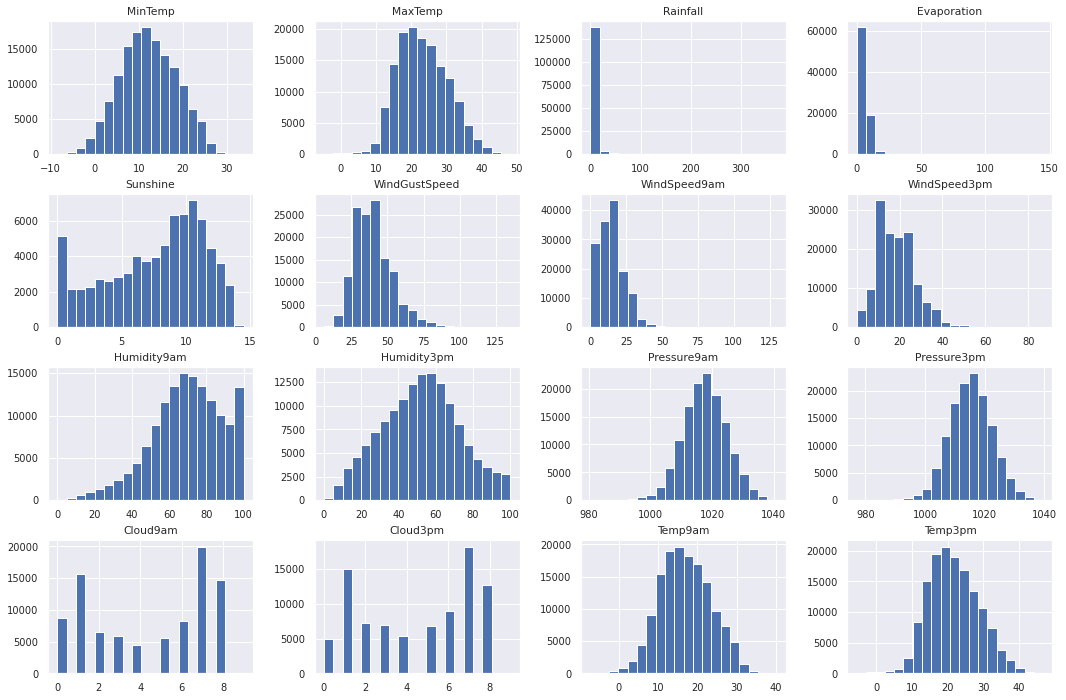

In [150]:
df_hist = df.hist(bins=20, figsize=(18,12))

A partir de lo observado en los histogramas podemos realizar las siguientes aseveraciones:
* La temperatura máxima y mínima tienen distribiciones normales, siendo claramente la media de la máxima mayor a la mínima.
* Tanto Rainfall como Evaporation cuentan con posibles valores extremos, además de tener un gran porcentaje de valores Nan (de la tabla de estatus).
* Ambas velocidades del viento poseen distribuciones sesgadas a la derecha.
* El valor máximo de humedad es 100, pudiendo indicar un límite en el dispositivo de medición o porque podríamos estar ante un porcentaje.
* Las distribuciones de presión a lo largo del día son normales y muy similares. Lo mismo se da para la temperatura.

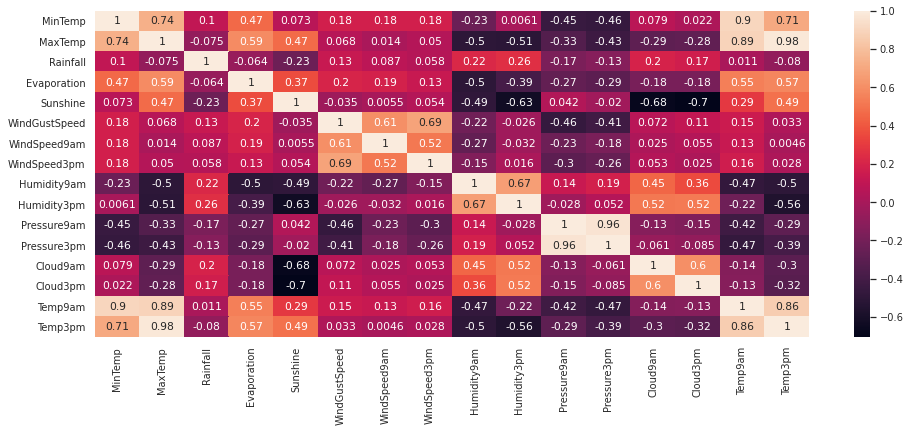

In [151]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True )

A través de un análisis de correlación podemos observar como las variables con dos mediciones dentro de un mismo día presentan una relación lineal con coeficiente cercano a 1. De modo de indagar más procedemos a calcular el rango como porcentaje de el máximo valor diario:

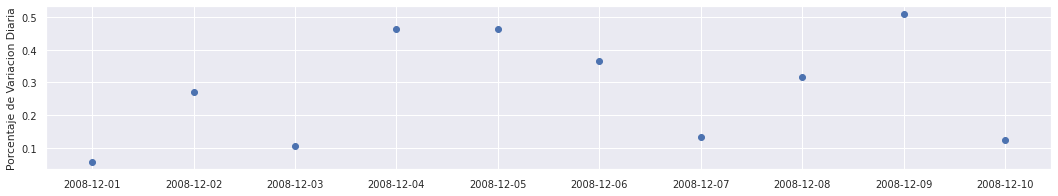

El porcentaje maximo de variacion diaria es 2%

In [152]:
pressure_dif = abs(df.Pressure3pm - df.Pressure9am)/max(df.Pressure3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(df.Date[0:10], pressure_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(pressure_dif))))

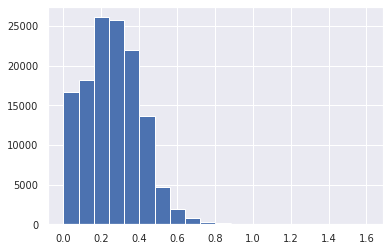

In [153]:
pressure_dif.hist(bins=20)

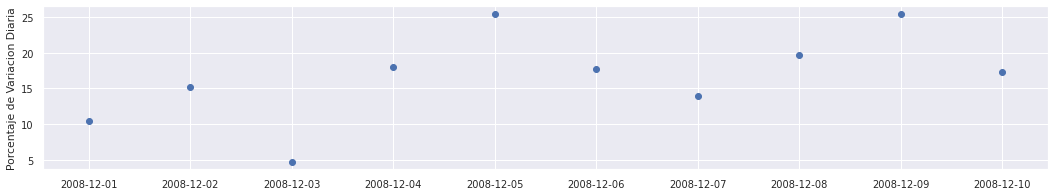

El porcentaje maximo de variacion diaria es 49%

In [154]:
temp_dif = abs(df.Temp3pm - df.Temp9am)/max(df.Temp3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(df.Date[0:10], temp_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(temp_dif))))

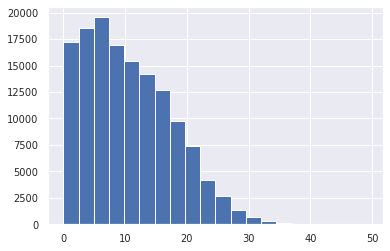

In [155]:
temp_dif.hist(bins=20)

De esta manera observamos como la variación de presión diara es muy baja en comparación a la de temperatura. Además se verifica la distribución de los porcentajes de variación para asegurarnos que el valor máximo no fue un valor extremo.

Procedemos a analizar la cardinalidad de las variables categóricas del dataset.

Text(0.5, 1.0, 'Cardinalidad')

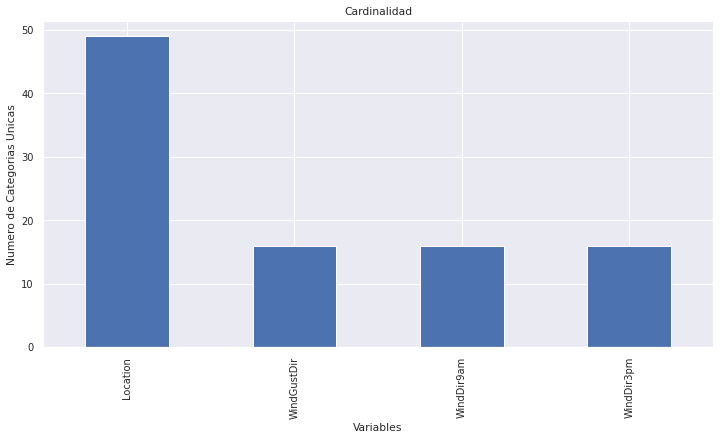

In [156]:
df_cat = df[['Location','WindGustDir', 'WindDir9am', 'WindDir3pm']]
df_cat.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Numero de Categorias Unicas')
plt.xlabel('Variables')
plt.title('Cardinalidad')

Analizamos la distribución de la distribución de los distintos valores que pueden tomar las variables asociadas al viento y la cantidad de datos por Location.

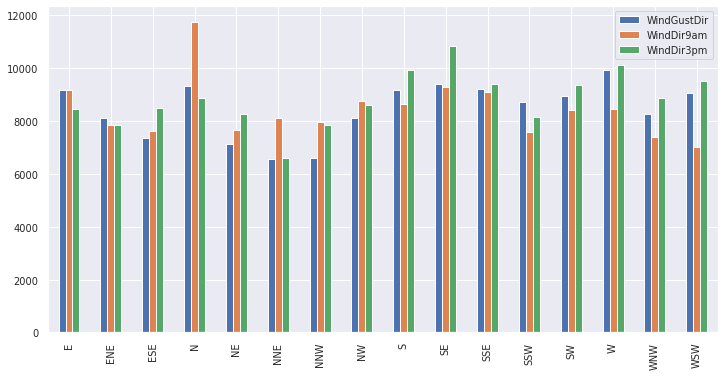

In [157]:
df_wind = df_cat.drop(['Location'], axis=1)
df_wind.apply(pd.Series.value_counts).plot(figsize=(12,6), kind='bar', stacked=False)

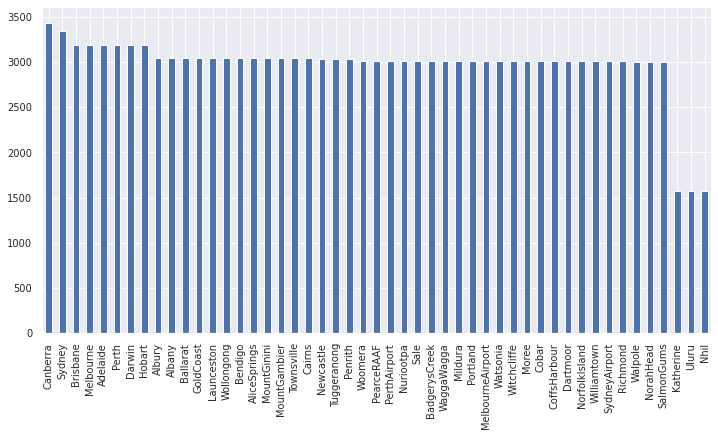

In [158]:
df_cat.Location.value_counts().plot(figsize=(12,6), kind='bar', stacked=False)

Finalmente observamos la distribución de la variable que indica si llovió hoy, observando un claro sesgo.

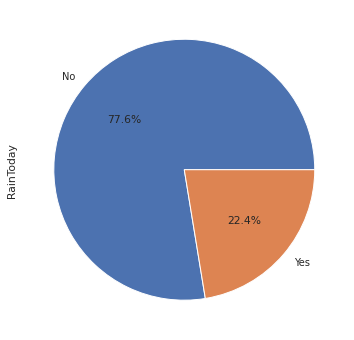

In [159]:
df.RainToday.value_counts().plot(figsize=(12,6), kind='pie', autopct='%1.1f%%')

#### Variables de Salida

En el siguiente gráfico de torta se observa un claro desbalance de clases en la variable de salida.

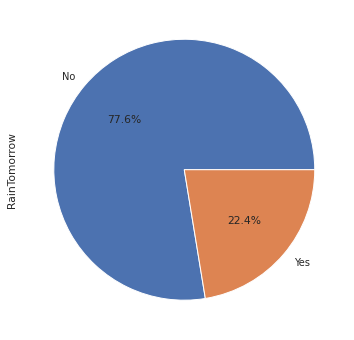

In [160]:
df.RainTomorrow.value_counts().plot(figsize=(12,6), kind='pie', autopct='%1.1f%%')

In [161]:
count = 0
for i in range(0, len(df.RainToday)):
  if df.RainToday[i] == df.RainTomorrow[i]:
    count = count + 1
percent = round(count/len(df.RainToday)*100, 2)


In [162]:
md("Un {}% de las observaciones, corresponde a casos en los que llovio al dia siguiente de un dia de lluvia.".format(percent))

Un 73.78% de las observaciones, corresponde a casos en los que llovio al dia siguiente de un dia de lluvia.

Nos encontramos ante un caso de clasificacion con dos clases de salida, por lo que la solucion mas adecuada es un Binary Enconding, donde Yes=1 y No=0. Si consideramos un modelo constante, y predecimos lluvia para un dia considerando que llovió el dia anterior, entonces obtendremos un 73,78% de acierto aproximado en el set de entrenamiento.

### 2. Esquema de validación de resultados

- Los pasos siguientes comprenden las etapas de preparación de datos y evaluación de resultados. 
- Para ello, se debe particionar el dataset en entrenamiento y validación.


In [163]:
X_train, X_test, y_train, y_test = split(df, test_size=0.2)

### 3. Limpieza y preparación de datos

Calculamos la cantidad de observaciones y valores faltantes para cada variable. La transformaciones serán probadas sobre el dataset de train y luego directamente aplicadas sobre el de test.



In [164]:
fp.status(y_train)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,RainTomorrow,2607,0.022403,0,0.0,2,object


Eliminamos los valores nan de la variable de salida para evitar que se genere overfitting al imputarlos.

In [165]:
y_train = y_train.dropna(axis=0)
X_train = X_train[X_train.index.isin(y_train.index)]

In [166]:
status = fp.status(X_train)
status[status['q_nan'] != 0]

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
2,MinTemp,510,0.004483,121,0.001064,386,float64
3,MaxTemp,261,0.002294,9,0.000079,499,float64
4,Rainfall,1116,0.009810,72269,0.635270,649,float64
5,Evaporation,48781,0.428802,185,0.001626,336,float64
6,Sunshine,54326,0.477545,1835,0.016130,145,float64
7,WindGustDir,7484,0.065787,0,0.000000,16,object
8,WindGustSpeed,7439,0.065391,0,0.000000,67,float64
9,WindDir9am,7993,0.070261,0,0.000000,16,object
10,WindDir3pm,3055,0.026855,0,0.000000,16,object
11,WindSpeed9am,1083,0.009520,6870,0.060390,43,float64


Se realiza un proceso completo de limpieza y preparación de datos como primera implementación y luego se agregan variantes en función de los resultados obtenidos en la validación.

Se identifican todas las variables cuyo porcentaje de nans es menor al 5% y se refleja en un grafico de barras ordenado.

<BarContainer object of 11 artists>

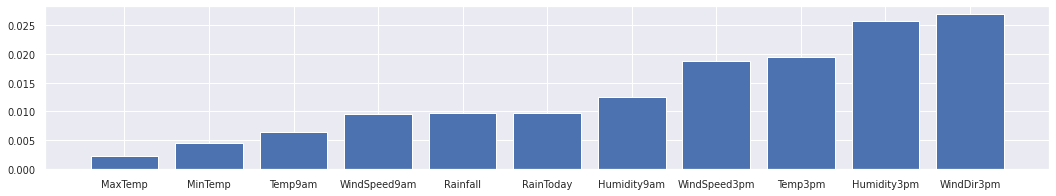

In [167]:
data_nan = status[['variable','p_nan']][(status['p_nan']<0.05) & (status['p_nan']>0)]
data_nan = data_nan.sort_values(by = ['p_nan'], axis=0)
plt.figure(figsize=(18, 3))
plt.bar(data_nan.variable, data_nan.p_nan)

Para cada una de las variables que presentan Nan, aislamos el bloque de datos y calculamos que porcentaje de nan sobre las otras variables. Nos encontramos con que al menos un 37% del bloque aislado tiene Nans.

In [168]:
for c in data_nan.variable.tolist():
  train_nan = X_train[X_train[c].isna()]
  status_nan = fp.status(train_nan)
  prom = round(sum(status_nan['p_nan'])/len(status_nan)*100,2)
  print('Considerando la porción del dataset con nan para {}, el promedio de nan de las demás variables es {}%.'.format(c,prom))

Considerando la porción del dataset con nan para MaxTemp, el promedio de nan de las demás variables es 47.13%.
Considerando la porción del dataset con nan para MinTemp, el promedio de nan de las demás variables es 51.35%.
Considerando la porción del dataset con nan para Temp9am, el promedio de nan de las demás variables es 49.97%.
Considerando la porción del dataset con nan para WindSpeed9am, el promedio de nan de las demás variables es 51.43%.
Considerando la porción del dataset con nan para Rainfall, el promedio de nan de las demás variables es 31.03%.
Considerando la porción del dataset con nan para RainToday, el promedio de nan de las demás variables es 31.03%.
Considerando la porción del dataset con nan para Humidity9am, el promedio de nan de las demás variables es 37.38%.
Considerando la porción del dataset con nan para WindSpeed3pm, el promedio de nan de las demás variables es 48.03%.
Considerando la porción del dataset con nan para Temp3pm, el promedio de nan de las demás varia

Por ello procedemos a eliminar todos las filas con Nan para las variables cuyo porcentaje es menor al 5% y verificamos que porcentaje del dataset original estariamos perdiendo.

In [169]:
len_old = X_train.shape[0]
X_train_nan = X_train.dropna(subset=data_nan.variable.to_list())
len_new = X_train_nan.shape[0]
print('Porcentaje de reducción del dataset {}%'.format(round(100-len_new/len_old*100,2)))


Porcentaje de reducción del dataset 5.38%


In [170]:
status_2 = fp.status(X_train_nan)
status_2[status_2['q_nan']!=0]

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
5,Evaporation,44971,0.417799,172,0.001598,330,float64
6,Sunshine,49529,0.460144,1771,0.016453,145,float64
7,WindGustDir,4828,0.044854,0,0.000000,16,object
8,WindGustSpeed,4819,0.044770,0,0.000000,66,float64
9,WindDir9am,6029,0.056012,0,0.000000,16,object
15,Pressure9am,8997,0.083586,0,0.000000,540,float64
16,Pressure3pm,8948,0.083130,0,0.000000,536,float64
17,Cloud9am,40155,0.373056,6403,0.059486,10,float64
18,Cloud3pm,41243,0.383164,3859,0.035852,10,float64


Procedemos a imputar las variables numéricas. En primera instancia imputaremos con la media a las variables cuyo histograma no es sesgado.

In [ ]:
X_train_nan.loc[:,:] = simple_imputer(X_train_nan, 'Cloud3pm', strategy='mean')
X_train_nan.loc[:,:] = simple_imputer(X_train_nan, 'Cloud9am', strategy='mean')
X_train_nan.loc[:,'Cloud3pm'] = X_train_nan['Cloud3pm'].round()
X_train_nan.loc[:, 'Cloud9am'] = X_train_nan['Cloud9am'].round()

X_train_nan.loc[:,:] = simple_imputer(X_train_nan, 'Pressure3pm', strategy='mean')
X_train_nan.loc[:,:] = simple_imputer(X_train_nan, 'Pressure9am', strategy='mean')

Luego imputamos las variables con distribuciones sesgadas por la mediana.

In [ ]:
X_train_nan.iloc[:,:] = simple_imputer(X_train_nan, 'Evaporation', strategy='median')
X_train_nan.iloc[:,:] = simple_imputer(X_train_nan, 'Sunshine', strategy='median')
X_train_nan.iloc[:,:] = simple_imputer(X_train_nan, 'WindGustSpeed', strategy='median')

Para el caso de las faltantes de variables categóricas completamos con una categoría diferente (Faltante).

In [ ]:
X_train_nan.loc[:, 'WindGustDir'] = X_train_nan['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
X_train_nan.loc[:, 'WindDir9am'] = X_train_nan.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)

Las variables categóricas a imputar corresponden a las direcciones de los vientos. Una forma de representarlos es a través de los ángulos asociados de 0° a 360°. (https://www.surfertoday.com/windsurfing/how-to-read-wind-direction). Para el caso Nan reemplazado por la palabra "Faltante" utilizamos el número -1.

In [174]:
dic = {'SE': 135, 'SSE': 157.5, 'W': 270, 'N':0, 'ENE':67.5, 'NW': 315, 'SSW': 202.5, 'SW':225, 'ESE': 112.5,
       'S': 180, 'NNW': 337.5, 'Faltante': -1, 'NNE': 22.5, 'E': 90, 'WSW': 247.5, 'WNW': 292.5, 'NE': 45}

In [ ]:
X_train_nan.loc[:, 'WindGustDir'] = X_train_nan['WindGustDir'].map(dic)
X_train_nan.loc[:, 'WindDir9am'] = X_train_nan['WindDir9am'].map(dic)
X_train_nan.loc[:, 'WindDir3pm'] = X_train_nan['WindDir3pm'].map(dic)

Tanto para la salida, como para la variable RainToday llevamos a cabo una codificación binaria ya que sólo toma uno de dos valores posibles.

In [ ]:
X_train_nan.loc[:, 'RainToday'] = X_train_nan.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
y_train = y_train.map({'No': 0, 'Yes': 1})

La fecha es dividida en año, mes y dia, todas como variables enteras.

In [177]:
date = X_train_nan.Date.str.split(pat='-', expand=True)

Para las Location usaremos una codificación de OneHotEncoding. Otra posibilidad podrías ser utilizar un embedding.

In [178]:
encoded_locations = one_hot_encoder(X_train_nan['Location'])

Para el caso en que se eliminan filas con valores Nan es necesario realizar lo mismo sobre la salida (usando el indice de las variables) para evitar que se mezcle la información.

In [179]:
y_train = y_train[y_train.index.isin(X_train_nan.index)]

Reseteamos los indices y concatenamos las fechas, ciudades y las demás variables. Luego finalmente eliminamos las columnas de las variables categóricas originales.

In [180]:
X_train_nan.reset_index(drop=True, inplace=True)
date.reset_index(drop=True, inplace=True)
encoded_locations.reset_index(drop=True, inplace=True)

In [181]:
X_train = pd.concat([X_train_nan, date, encoded_locations], axis=1)
X_train_loc = pd.concat([X_train_nan, date], axis=1)

In [182]:
X_train = X_train.drop(['Location', 'Date'], axis=1)

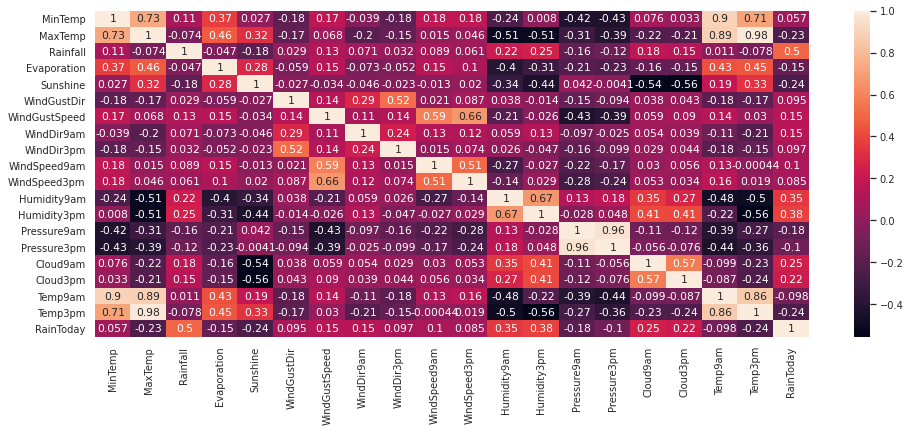

In [183]:
plt.figure(figsize=(16, 6))
sns.heatmap(X_train_loc.corr(), annot=True )

Se observa una gran relación lineal entre las variables asociadas a las temperaturas, de la misma manera que la presión. Se podría prescindir de una variable asociada a la presión y/o utilizar por ejemplo, la diferencia entre las temperaturas en el día.

In [194]:
X_train_loc['RainTomorrow'] = y_train.values

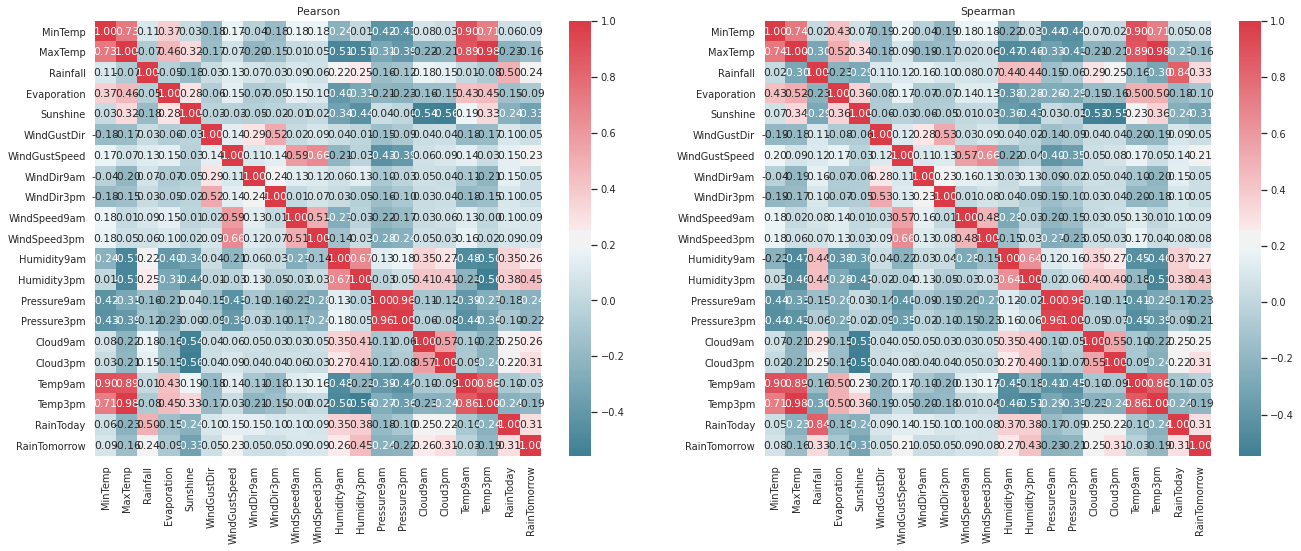

In [196]:
fig, axes = plt.subplots(1,2,figsize=(22,8))

r = X_train_loc.corr(method='pearson')
axes[0].set_title("Pearson")
sns.heatmap(r, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

rho = X_train_loc.corr(method='spearman')
axes[1].set_title("Spearman")
sns.heatmap(rho, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

Podemos observar que tanto para el coeficiente de Pearson como Spearman, la salida no presenta una correlación significativa con alguna de las variables de entrada. Las relaciones más prepoderantes se dan con la humedad de tarde y la condición de lluvia/ no lluevia del día actual.

### 4. Entrenamiento de modelos

##### Modelo 1

In [197]:
df = pd.read_csv(file_path)
X_train, X_test, y_train, y_test = split(df, test_size=0.2)
X_train, y_train, left = preprocessing(X_train, y_train)
X_test, y_test, left = preprocessing(X_test, y_test)

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler  

std = StandardScaler()
clf = LogisticRegression()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [205]:
print("Precisión sobre el set de entrenamiento {} %".format(round(clf.score(X_train, y_train),4)*100))

Precisión sobre el set de entrenamiento 85.38 %


In [206]:
print("Precisión sobre el set de testeo {} %".format(round(clf.score(X_test, y_test),4)*100))

Precisión sobre el set de testeo 85.16 %


##### Modelo 2

In [210]:
df = pd.read_csv(file_path)
X_train, X_test, y_train, y_test = split(df, test_size=0.2)
X_train, y_train, left = preprocessing(X_train, y_train)
X_test, y_test, left = preprocessing(X_test, y_test)

In [211]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler  

std = StandardScaler()
rf = RandomForestClassifier()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [212]:
print("Precisión sobre el set de entrenamiento {} %".format(round(rf.score(X_train, y_train),4)*100))

Precisión sobre el set de entrenamiento 100.0 %


In [213]:
print("Precisión sobre el set de testeo {} %".format(round(rf.score(X_test, y_test),4)*100))

Precisión sobre el set de testeo 85.76 %




### 5. Evaluación de resultados y conclusiones

- ¿Qué puede concluir acerca de los modelos y preparaciones de datos ensayadas? Tener en cuenta como cada preparación afecta a los distintos modelos.

### 7. Presentación de resultados

- Elabore un informe de dos o tres páginas describiendo el procedimiento realizado y las conclusiones importantes indicando la ruta del código fuente en git.